In [1]:
from neuron import h, load_mechanisms
from netpyne import specs, sim
import matplotlib.pyplot as plt
import os
import numpy as np

--No graphics will be displayed.


In [4]:
h.load_file("stdrun.hoc")

cwd = os.getcwd()
mod_dir = '/Users/katedoxey/Desktop/research/projects/tinnitus model/code/DCN_model/mod'
mod_dir = '/home/kedoxey/DCN_model/mod'
load_mechanisms(mod_dir)

Mechanisms already loaded from path: /home/kedoxey/DCN_model/mod.  Aborting.


True

In [5]:
cell_types = ['P']  #['P', 'I2', 'W', 'AN']
record_cells = [(f'{cell_type}_pop', 0) for cell_type in cell_types]

dt = 0.001

cfg = specs.SimConfig()	
cfg.duration = 1200				                 
cfg.dt = dt								                # Internal integration timestep to use
cfg.verbose = True							                # Show detailed messages
cfg.recordCells = ['all']
cfg.recordTraces = {'V_soma': {'sec': 'soma', 'loc': 0.5, 'var': 'v'}}
cfg.recordStep = dt
# cfg.recordStim = True
# cfg.filename = os.path.join(sim_dir, f'{sim_label}-DCN') 	# Set file output name
cfg.savePickle = False
# cfg.analysis['plotTraces'] = {'include': ['all'], 'saveFig': False, 'showFig': False}  # Plot recorded traces for this list of cells
# cfg.analysis['recordTraces'] = 
# cfg.analysis['plotSpikeFreq'] = {'include': ['all'], 'saveFig': True, 'showFig': True}
cfg.hParams['celsius'] = 34.0 
cfg.hParams['v_init'] = -60

In [6]:
netParams = specs.NetParams()

IzhCell = {'secs': {}}
IzhCell['secs']['soma'] = {'geom': {}, 'pointps': {}}                        # soma params dict
IzhCell['secs']['soma']['geom'] = {'diam': 10.0, 'L': 10.0, 'cm': 31.831}    # soma geometry, cm = 31.831
IzhCell['secs']['soma']['pointps']['Izhi'] = {                               # soma Izhikevich properties
    'mod':'Izhi2007b',
    'C':1,
    'k': 0.7,
    'vr':-60,
    'vt':-40,
    'vpeak':35,
    'a':0.03,
    'b':-2,
    'c':-50,
    'd':100,
    'celltype':1}
# IzhCell['secs']['soma']['threshold'] = -20
netParams.cellParams['IzhCell'] = IzhCell 


In [7]:
n_cells = 1

pop_labels_nums = {cell_type: n_cells for cell_type in cell_types}

for pop_label, pop_num in pop_labels_nums.items():
    netParams.popParams[f'{pop_label}_pop'] = {'cellType': 'IzhCell',
                                                'numCells': pop_num}

In [6]:

# netParams.popParams[f'vecstim_ANF'] = {
#     'cellModel': 'VecStim',
#     'numCells': 1,  # int(len(syn_secs)/4),
#     'spikePattern': {'type': 'poisson',
#                     'start': stim_delay,
#                     'stop': stim_dur+stim_delay,
#                     'frequency': np.random.uniform(20,40)}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
# }

# netParams.connParams[f'vecstim_AFN->P'] = {
#     'preConds': {'pop': f'vecstim_ANF'},
#     'postConds': {'pop': [f'{cell_type}_pop' for cell_type in cell_types]},
#     'sec': 'soma',
#     'synsPerConn': 1,
#     'synMech': 'exc',
#     'weight': syn_weight,  # 
#     # 'synMechWeightFactor': [0.5,0.5],
#     'delay': 'defaultDelay + dist_2D/propVelocity',
#     'connList': [[0,i] for i in range(len(cell_types))]
# }

In [ ]:
e_tau = 0.2
# netParams.synMechParams['exc'] = {'mod': 'ExpSyn', 'tau': e_tau, 'e': 10}
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 1.0, 'e': 0} 

## NetStim Parameters
prefer control of Poisson spike trains


Start time:  2025-02-27 14:11:50.158225

Creating network of 1 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop P_pop, on node 0, 
Instantiated 1 cells of population P_pop
  Number of cells on node 0: 1 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Created bkg NetStim for cell gid=0
  Created connection preGid=bkg NetStim, postGid=0, sec=soma, loc=0.5, synMech=exc, weight=0.2, delay=6.21
  Number of stims on node 0: 1 
  Done; cell stims creation time = 0.00 s.
  Recording  V_soma from cell  0  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[92]
   Recording h.t
   Recording: V_soma:
      cell_0
Recording 1 traces of 1 types on node 0

Setting h global variables ...
  h.celsius = 34.0
  h.v_init = -60
  h.clamp_resist = 0.001
  h.tstop = 1200.0
Minimum delay (time-step for queue exchange) is

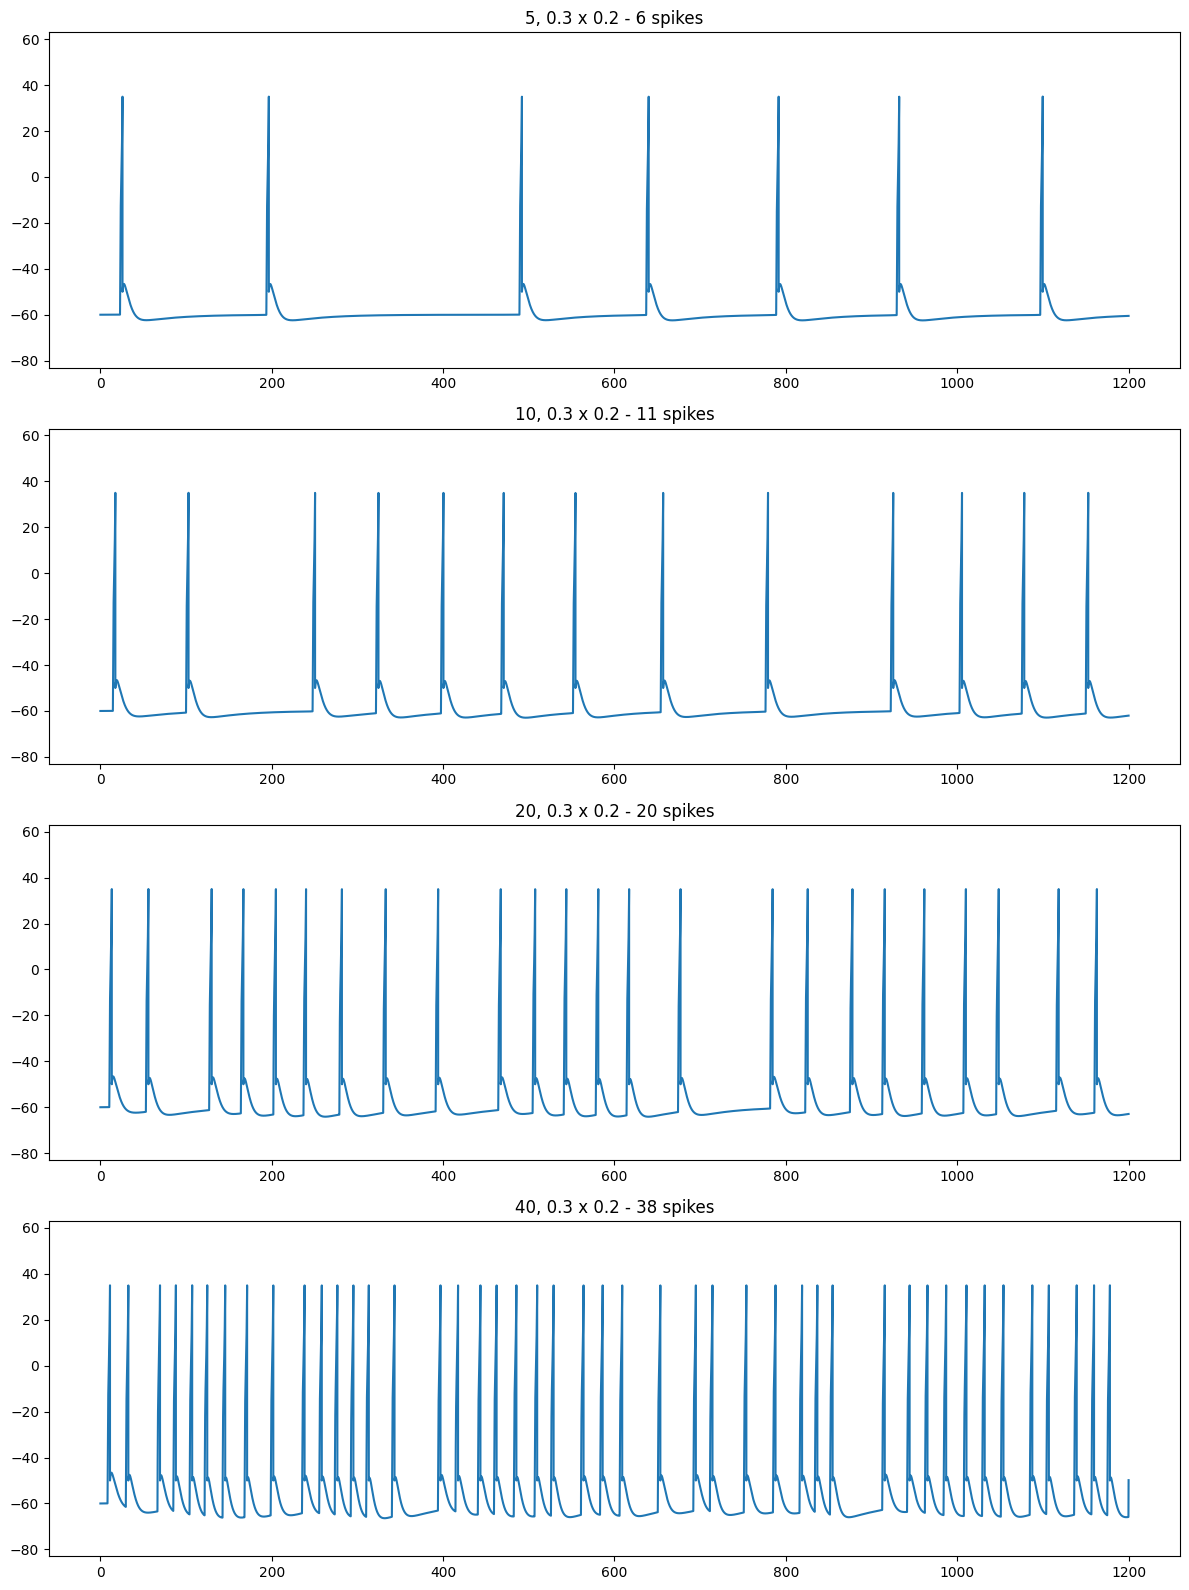

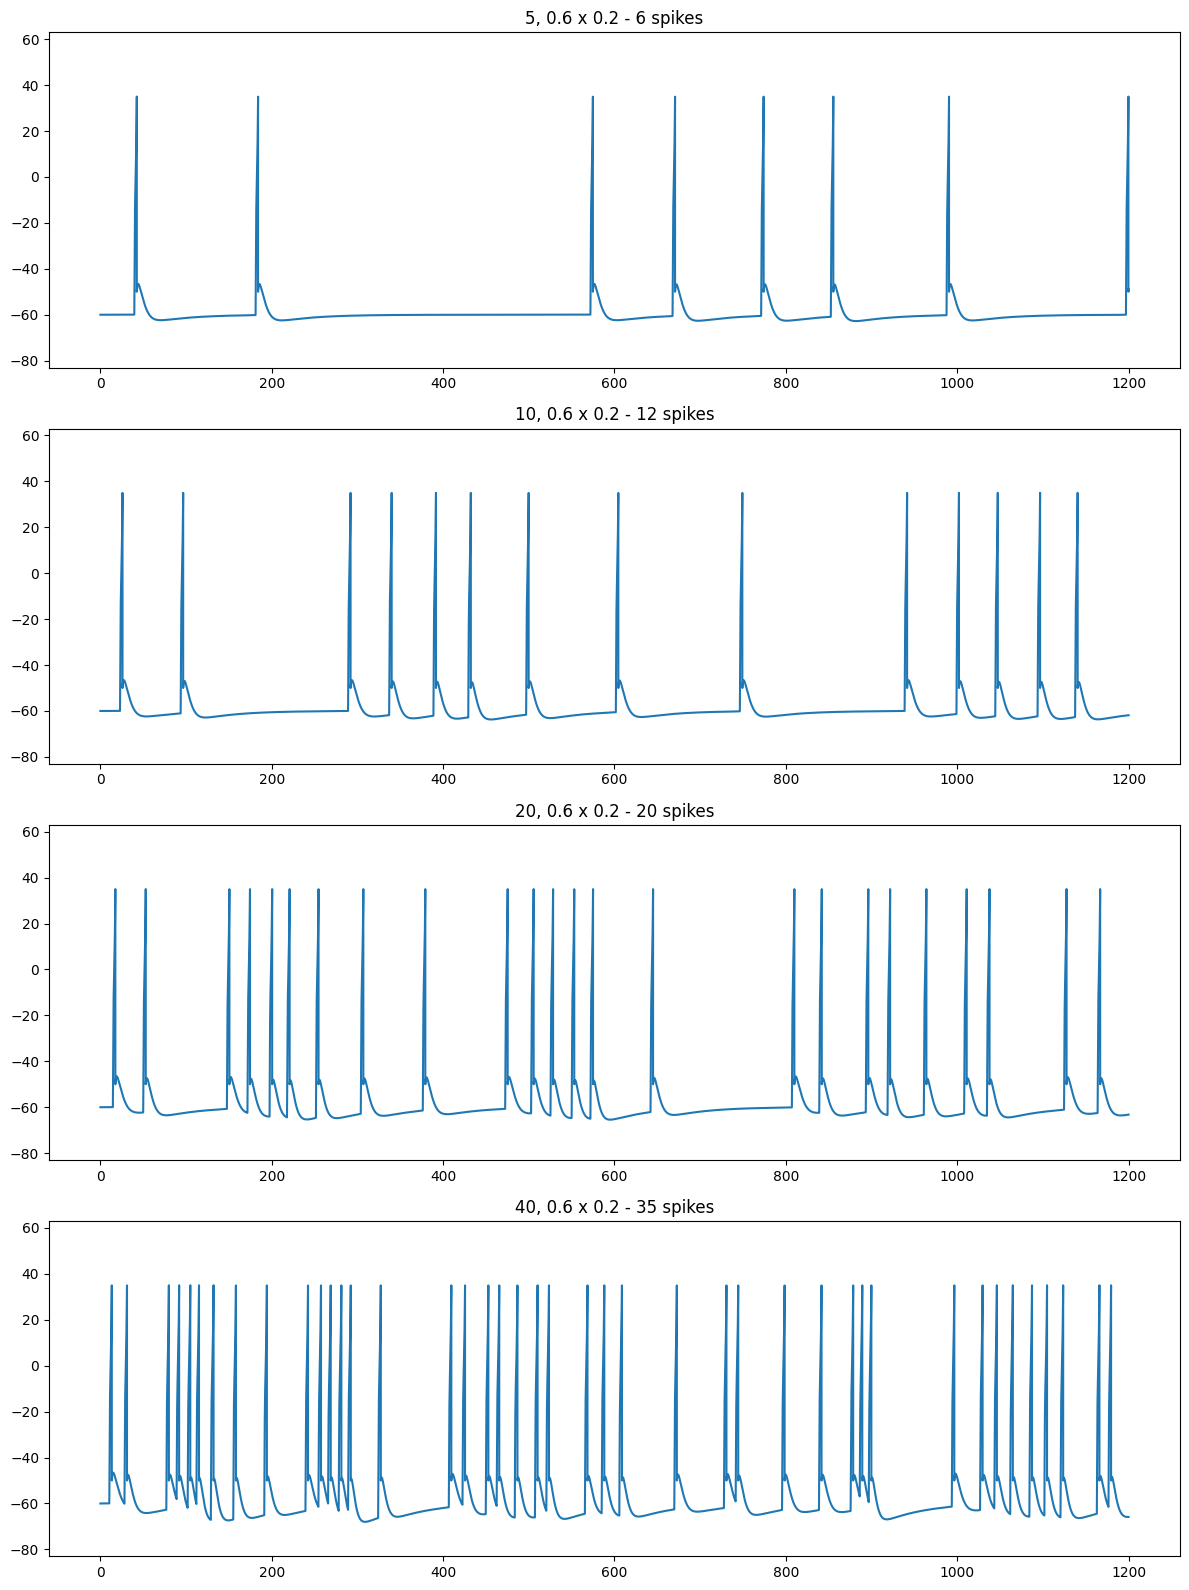

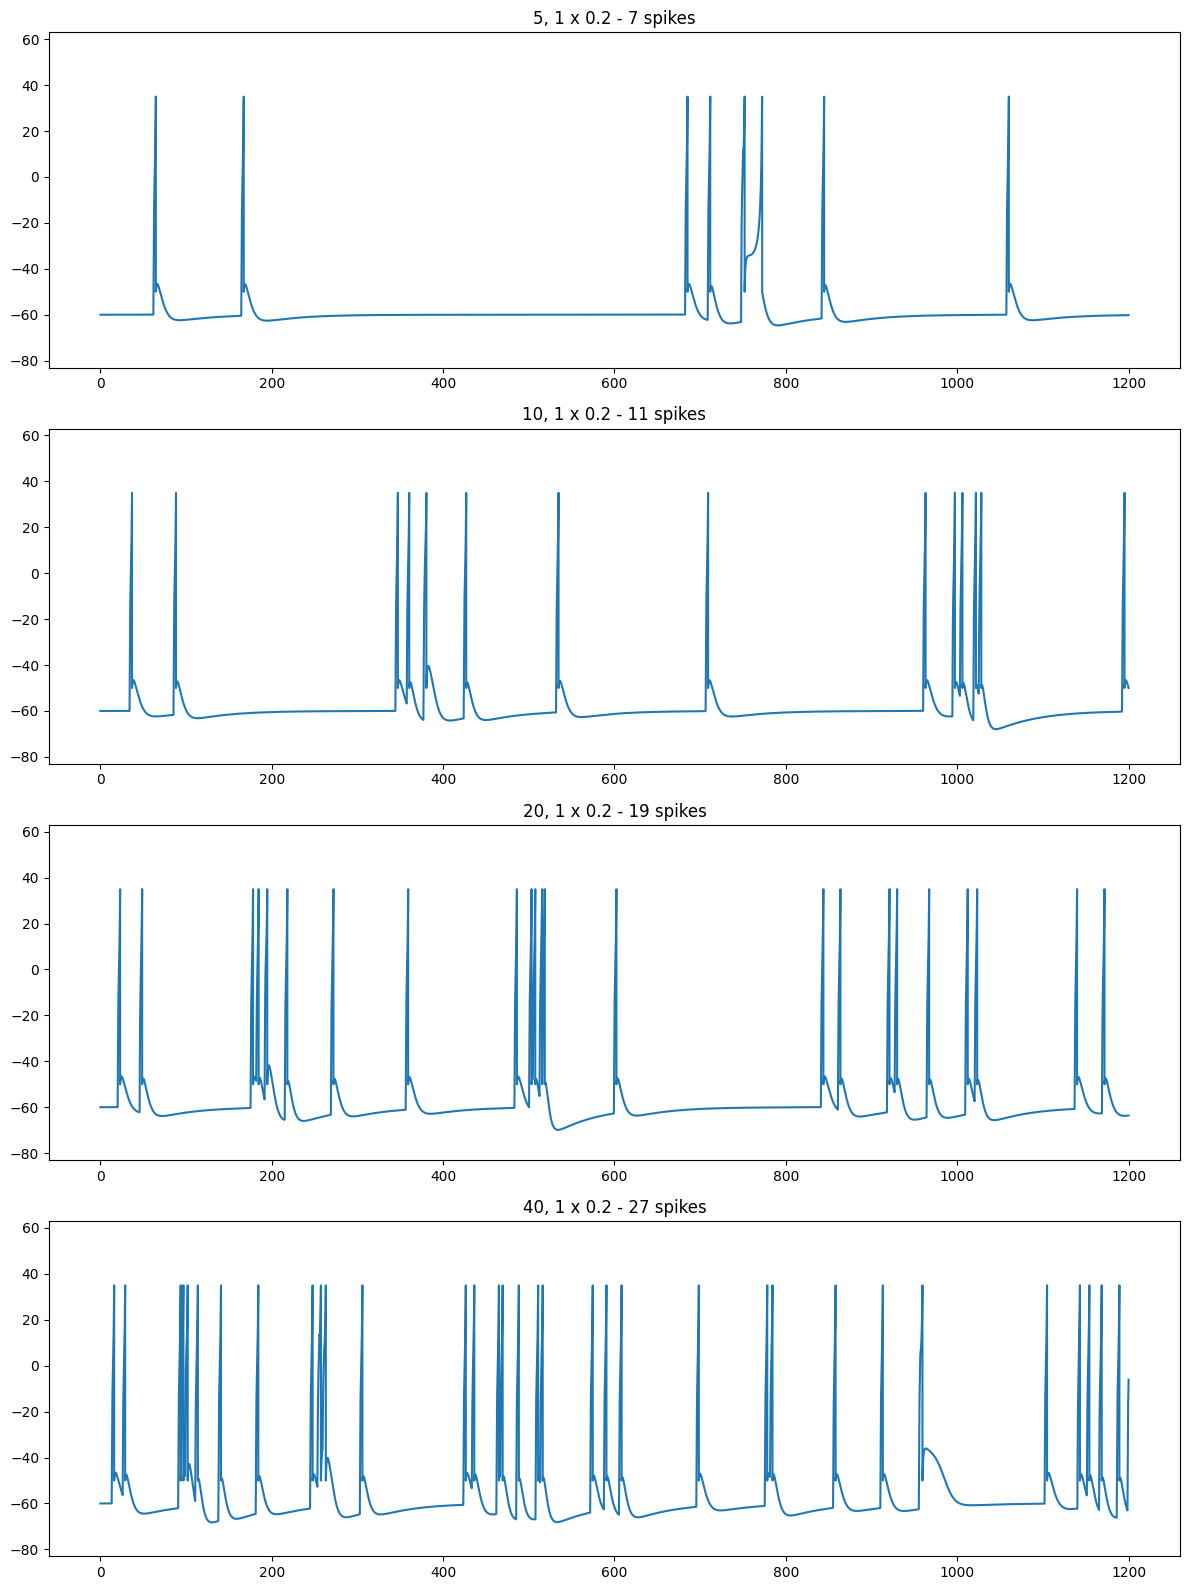

In [13]:
%matplotlib inline

ns_rates = [5, 10, 20, 40]
ns_noises = [0.3, 0.6, 1]
# ns_weights = [0.2, 0.5, 1]

stim_delay = 100
stim_dur = 1000

for ns_noise in ns_noises:

    fig, axs = plt.subplots(len(ns_rates), 1, figsize=(12,4*len(ns_rates)))

    for i, ns_rate in enumerate(ns_rates):
        # ns_rate = 20
        # ns_noise = 0.3
        ns_weight = 0.2

        netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': ns_rate, 'noise': ns_noise}
        netParams.stimTargetParams['bkg->all'] = {'source': 'bkg', 'conds': {'cellType': ['IzhCell']}, 'weight': ns_weight, 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

        (pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

        temp = 5

        spkt = np.array(simData['spkt'])
        spkid = np.array(simData['spkid'])

        spikes = spkt[np.where(spkid == 0)]
        msf = round((len(spikes) - 1) / (spikes[-1] - spikes[0]) * 1000) if len(spikes) > 0 else 0

        nsa_train = spkt[np.where(spkid == 1)]
        # inh_train = spkt[np.where(spkid == 2)]

        # if (i%3 == 0)and (in_amp > 0):
        t = np.array(simData['t'])
        V_soma = np.array(simData['V_soma']['cell_0'])

        axs[i].plot(t, V_soma)
        # if i_syn_weight > 0:
        #     axs[i].vlines(inh_train, ymin=-5, ymax=5, color='k')
        axs[i].vlines(nsa_train, ymin=20, ymax=27, color='g')
        axs[i].set_title(f"{ns_rate}, {ns_noise} x {ns_weight} - {msf} spikes")
        axs[i].set_ylim(-83, 63)

    fig.tight_layout()
# print(f'{nsa_freq}Hz-diff_weights-{e_tau}tau.png')
# fig.savefig(f'{nsa_freq}Hz-diff_weights-{e_tau}tau.png', dpi=300)

## NSA parameters
Poisson frequency = 55 Hz for spike frequency = 37 Hz


Start time:  2025-02-28 13:39:23.688544

Creating network of 2 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop P_pop, on node 0, 
Instantiated 1 cells of population P_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[0]
Cell 0/0 (gid=1) of pop vecstim_NSA, on node 0, 
Instantiated 1 cells of population vecstim_NSA
  Number of cells on node 0: 2 
  Done; cell creation time = 0.00 s.
Making connections...
Generating set of connections from list (rule: vecstim_NSA->P) ...
  Created connection preGid=1, postGid=0, sec=soma, loc=0.5, synMech=exc, weight=0.2, delay=1.12
  Number of connections on node 0: 1 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
  Recording  V_soma from cell  0  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[4]
  Cannot record  V_soma from 

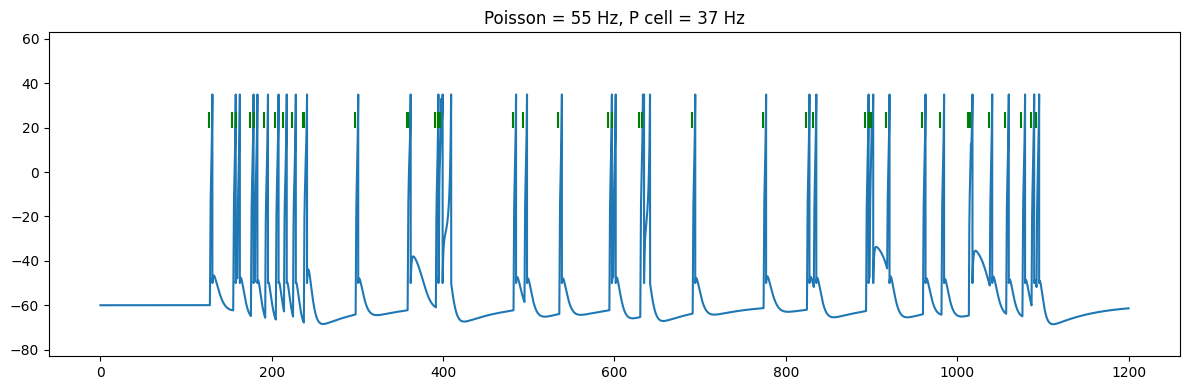


Start time:  2025-02-28 13:43:20.473286

Creating network of 2 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop P_pop, on node 0, 
Instantiated 1 cells of population P_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[1]
Cell 0/0 (gid=1) of pop vecstim_NSA, on node 0, 
Instantiated 1 cells of population vecstim_NSA
  Number of cells on node 0: 2 
  Done; cell creation time = 0.00 s.
Making connections...
Generating set of connections from list (rule: vecstim_NSA->P) ...
  Created connection preGid=1, postGid=0, sec=soma, loc=0.5, synMech=exc, weight=0.2, delay=1.12
  Number of connections on node 0: 1 
  Done; cell connection time = 0.00 s.
  Number of stims on node 0: 0 
  Done; cell stims creation time = 0.00 s.
  Recording  V_soma from cell  0  with parameters:  {'sec': 'soma', 'loc': 0.5, 'var': 'v'}
Vector[11]
  Cannot record  V_soma from

KeyboardInterrupt: 

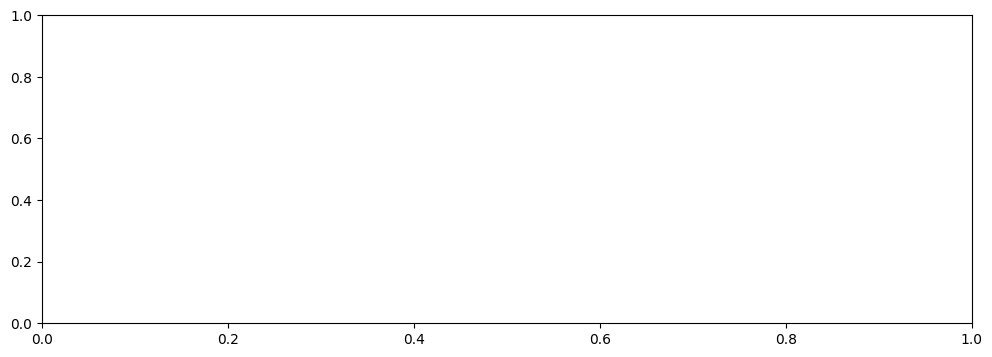

In [ ]:
%matplotlib inline

nsa_freqs = [55]

stim_delay = 100
stim_dur = 1000

fig, axs = plt.subplots(len(nsa_freqs), 1, figsize=(12,4*len(nsa_freqs)))

for i, nsa_freq in enumerate(nsa_freqs):

    netParams.popParams[f'vecstim_NSA'] = {
            'cellModel': 'VecStim',
            'numCells': n_cells,  # int(len(syn_secs)/4),
            'spikePattern': {'type': 'poisson',
                            'start': stim_delay,
                            'stop': stim_dur+stim_delay,
                            'frequency': nsa_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
        }

    netParams.connParams[f'vecstim_NSA->P'] = {
        'preConds': {'pop': f'vecstim_NSA'},
        'postConds': {'pop': 'P_pop'},
        'sec': 'soma',
        'synsPerConn': 1,
        'synMech': 'exc',
        'weight': 0.2,  # 
        # 'synMechWeightFactor': [0.5,0.5],
        'delay': 'defaultDelay + dist_2D/propVelocity',
        'connList': [[i,i] for i in range(n_cells)]
        }
    

    (pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

    temp = 5

    spkt = np.array(simData['spkt'])
    spkid = np.array(simData['spkid'])

    spikes = spkt[np.where(spkid == 0)]
    msf = round((len(spikes) - 1) / (spikes[-1] - spikes[0]) * 1000) if len(spikes) > 0 else 0

    nsa_train = spkt[np.where(spkid == 1)]
    # inh_train = spkt[np.where(spkid == 2)]

    # if (i%3 == 0)and (in_amp > 0):
    t = np.array(simData['t'])
    V_soma = np.array(simData['V_soma']['cell_0'])

    if len(nsa_freqs) == 1:
        ax = axs
    else:
        ax = axs[i]

    ax.plot(t, V_soma)
    # if i_syn_weight > 0:
    #     axs[i].vlines(inh_train, ymin=-5, ymax=5, color='k')
    ax.vlines(nsa_train, ymin=20, ymax=27, color='g')
    ax.set_title(f"Poisson = {nsa_freq} Hz, P cell = {msf} Hz")
    ax.set_ylim(-83, 63)

fig.tight_layout()
# print(f'{nsa_freq}Hz-diff_weights-{e_tau}tau.png')
fig.savefig(os.path.join('output', f'single_cell-{nsa_freq}Hz.png'), dpi=300)

## Inhibitory synapse parameters

In [17]:
nsa_freq = 65 

netParams.popParams[f'vecstim_NSA'] = {
        'cellModel': 'VecStim',
        'numCells': n_cells,  # int(len(syn_secs)/4),
        'spikePattern': {'type': 'poisson',
                        'start': stim_delay,
                        'stop': stim_dur+stim_delay,
                        'frequency': nsa_freq}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
    }

netParams.connParams[f'vecstim_NSA->P'] = {
    'preConds': {'pop': f'vecstim_NSA'},
    'postConds': {'pop': 'P_pop'},
    'sec': 'soma',
    'synsPerConn': 1,
    'synMech': 'exc',
    'weight': 0.2,  # 
    # 'synMechWeightFactor': [0.5,0.5],
    'delay': 'defaultDelay + dist_2D/propVelocity',
    'connList': [[i,i] for i in range(n_cells)]
    }


Start time:  2025-02-28 13:52:46.385771

Creating network of 3 cell populations on 1 hosts...
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
Cell 0/0 (gid=0) of pop P_pop, on node 0, 
Instantiated 1 cells of population P_pop
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[44]
Cell 0/0 (gid=1) of pop vecstim_NSA, on node 0, 
Instantiated 1 cells of population vecstim_NSA
Distributed population of 1 cells on 1 hosts: {0: [0]}, next: 0
    Error while setting 'spikePattern' param to VecStim[45]
Cell 0/0 (gid=2) of pop vecstim_inh, on node 0, 
Instantiated 1 cells of population vecstim_inh
  Number of cells on node 0: 3 
  Done; cell creation time = 0.00 s.
Making connections...
Generating set of connections from list (rule: vecstim_NSA->P) ...
  Created connection preGid=1, postGid=0, sec=soma, loc=0.5, synMech=exc, weight=0.2, delay=1.12
Generating set of connections from list (rule: vecstim_inh->P)

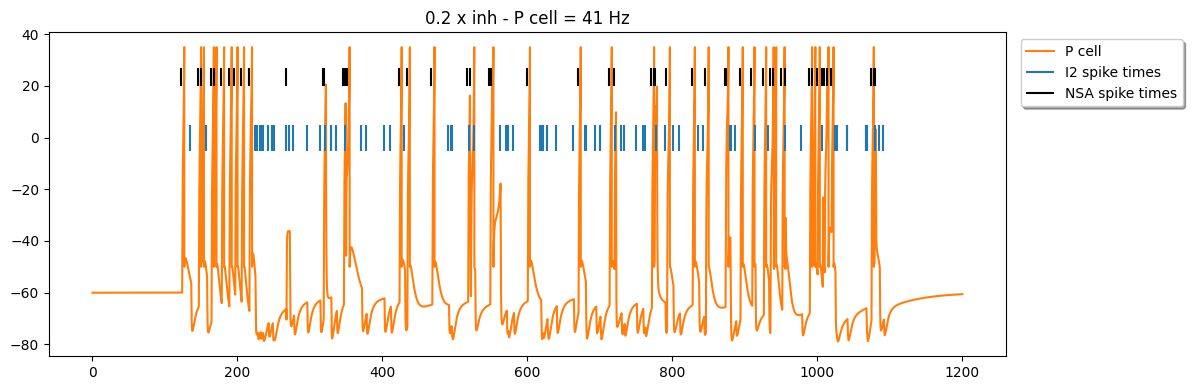

In [19]:
%matplotlib inline

# i_taus = [e_tau*25, e_tau*50]
i_syn_weights = [0.2]  # , 0.2]

fig, axs = plt.subplots(len(i_syn_weights), 1, figsize=(12,4*len(i_syn_weights)))


for i, i_syn_weight in enumerate(i_syn_weights):

    if len(i_syn_weights) == 1:
        ax = axs
    else:
        ax = axs[i]

    # i_tau = 0.4

    # netParams.synMechParams['inh'] = {'mod': 'ExpSyn', 'tau': i_tau, 'e': -70}
    netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.1, 'tau2': 1.0, 'e': -80}  

    netParams.popParams[f'vecstim_inh'] = {
        'cellModel': 'VecStim',
        'numCells': 1,  # int(len(syn_secs)/4),
        'spikePattern': {'type': 'poisson',
                        'start': stim_delay,
                        'stop': stim_dur+stim_delay,
                        'frequency': 80}  #  np.random.randint(params.spk_freq_lb, params.spk_freq_ub, 1)[0]}
    }

    netParams.connParams[f'vecstim_inh->P'] = {
        'preConds': {'pop': f'vecstim_inh'},
        'postConds': {'pop': [f'{cell_type}_pop' for cell_type in cell_types]},
        'sec': 'soma',
        'synsPerConn': 1,
        'synMech': 'inh',
        'weight': i_syn_weight,  # 
        # 'synMechWeightFactor': [0.5,0.5],
        'delay': 'defaultDelay + dist_2D/propVelocity',
        'connList': [[0,i] for i in range(len(cell_types))]
    }
    

    (pops, cells, conns, stims, simData) = sim.createSimulateAnalyze(netParams=netParams, simConfig=cfg, output=True)

    temp = 5

    spkt = np.array(simData['spkt'])
    spkid = np.array(simData['spkid'])

    spikes = spkt[np.where(spkid == 0)]
    msf = round((len(spikes) - 1) / (spikes[-1] - spikes[0]) * 1000) if len(spikes) > 0 else 0

    exc_train = spkt[np.where(spkid == 1)]
    inh_train = spkt[np.where(spkid == 2)]

    # if (i%3 == 0)and (in_amp > 0):
    t = np.array(simData['t'])
    V_soma = np.array(simData['V_soma']['cell_0'])

    axs.plot(t, V_soma, color='tab:orange', label='P cell')
    if i_syn_weight > 0:
        axs.vlines(inh_train, ymin=-5, ymax=5, color='tab:blue', label='I2 spike times')
    axs.vlines(exc_train, ymin=20, ymax=27, color='k', label='NSA spike times')
    axs.set_title(f"{i_syn_weight} x inh - P cell = {msf} Hz")
    axs.legend(loc='upper center', bbox_to_anchor=(1.1, 1),
                  ncol=1, fancybox=True, shadow=True)

fig.tight_layout()
# print(f'{nsa_freq}Hz-diff_weights-{e_tau}tau.png')
fig.savefig(os.path.join('output', f'single_cell-{nsa_freq}Hz-{i_syn_weight}xI.png'), dpi=300)